In [1]:
# importing libraries the needed libraries.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.stats import zscore
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score




In [2]:
os.chdir(r'C:\Users\asus\Documents\Jupyter notebook projects\Customer segmentation')

In [3]:
df=pd.read_csv('OnlineRetail.csv',encoding='latin1') #Loading the csv dataset.

In [4]:
df.head() #Displaying the head of the dataset.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### Attribute Information:

* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides.

# Data Cleaning:

In [5]:
df.info() #Informations about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.isnull().sum()   #number of null values for each feature.

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

* Later we will perform RFM analysis for each customer,so it is necessary to have the CustomerID column with no null values.  

In [7]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate']) #Changing the invoice date data type to date time.
df['CustomerID']=df['CustomerID'].astype(str)       #Casting the customer id variable to string type.
df.dropna(subset=['Description','CustomerID'],axis=0,inplace=True) #Dropping null values in customerId and Description.
df.drop_duplicates(inplace=True) #Dropping duplicates

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535187 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    535187 non-null  object        
 1   StockCode    535187 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     535187 non-null  int64         
 4   InvoiceDate  535187 non-null  datetime64[ns]
 5   UnitPrice    535187 non-null  float64       
 6   CustomerID   535187 non-null  object        
 7   Country      535187 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.7+ MB


# Exploratory and RFM Analysis:

In [9]:
df.describe() #Dataframe description

,Quantity,UnitPrice
count,535187.000000,535187.000000
mean,9.671593,4.645242
std,219.059056,97.364810
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


* We notice that the minimum value is -80995 which is negative,my guess is that a negative quantity represents goods returned by the buyer.
* The quantity data is way spread with and STD of 284.69 and a range of 161990, as we can see thereis a large gap between the 3rd quantile and the maximum.
* Same thing with UnitPrice, a very large data range and a narrow interquantile interval and that may due to the fact that The company mainly sells unique all-occasion gifts hence the disparity.




In [10]:
print("Number of transactions: ", df['InvoiceNo'].nunique())
print("Number of products bought: ", df['StockCode'].nunique())
print("Number of customers:", df['CustomerID'].nunique())
print('Number of countries: ', df['Country'].nunique())

Number of transactions:  24446
Number of products bought:  3958
Number of customers: 4373
Number of countries:  38


In [11]:
def count(col): # A function that returns number of values within a categorical feature
    return df[col].value_counts()


In [12]:
items_count=df.groupby(['Description'])[['Quantity']].sum() #Total sold quantity for each item
items_count

,Quantity
Description,
4 PURPLE FLOCK DINNER CANDLES,142
50'S CHRISTMAS GIFT BAG LARGE,1913
DOLLY GIRL BEAKER,2444
I LOVE LONDON MINI BACKPACK,388
I LOVE LONDON MINI RUCKSACK,1
...,...
wrongly marked carton 22804,-256
wrongly marked. 23343 in box,-3100
wrongly sold (22719) barcode,170


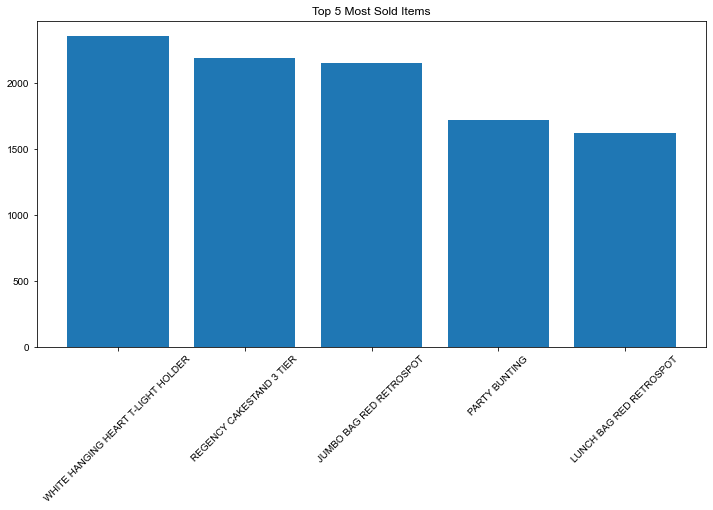

In [13]:
# Barplot for TOP 5 most sold items
fig,ax=plt.subplots(figsize=(12,6))
plt.style.use('seaborn')
ax.bar(count('Description')[:5].index,count('Description')[:5])
ax.set_title('Top 5 most sold items'.title())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)


In [14]:
count('Country')/len(df)*100    #percentage of sales by country

United Kingdom          91.341157
Germany                  1.771343
France                   1.595891
EIRE                     1.529185
Spain                    0.472358
Netherlands              0.443023
Belgium                  0.386594
Switzerland              0.372580
Portugal                 0.282144
Australia                0.235058
Norway                   0.202920
Italy                    0.150041
Channel Islands          0.141446
Finland                  0.129861
Cyprus                   0.114166
Sweden                   0.086138
Unspecified              0.082588
Austria                  0.074927
Denmark                  0.072685
Japan                    0.066893
Poland                   0.063716
Israel                   0.054934
USA                      0.054374
Hong Kong                0.053066
Singapore                0.042789
Iceland                  0.034007
Canada                   0.028214
Greece                   0.027280
Malta                    0.023730
United Arab Em

* 88.95% of the transactions occurred in the United  with Germany and France trailing behind with 2.33% and 2.08%  and that goes back to the fact that the retail is on british soil. 

In [15]:
#Calculating the canceled orders percentage

df_canceled=df[df['InvoiceNo'].str.contains('C')]
total_invoice=df['InvoiceNo'].nunique()
cancel_count=df_canceled['InvoiceNo'].nunique()
canceled_ratio=cancel_count/total_invoice
print('Percentage of orders cancelled: {:.2f}% '.format(canceled_ratio*100))


Percentage of orders cancelled: 15.69% 


In [16]:
df_canceled=df[df['InvoiceNo'].str.contains('C')]
df_canceled.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-01-12 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-01-12 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-01-12 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-01-12 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-01-12 10:24:00,0.29,17548.0,United Kingdom


In [17]:
df_canceled[df_canceled['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


* We notice that negative quantity values are attributed to canceled invoices.

In [18]:
df['Total']=df['Quantity']*df['UnitPrice']
per=df['InvoiceDate'].dt.to_period('M')
df_trans_date=df.groupby(per)[['InvoiceNo']].count()
df_sales_date=df.groupby(per)[['Total']].sum()
df_trans_date

,InvoiceNo
InvoiceDate,
2010-01,3054
2010-02,2066
2010-03,2155
2010-05,2620
2010-06,3820
2010-07,2938
2010-08,2599
2010-09,2843
2010-10,2721


In [19]:
df_trans_date.index=df_trans_date.index.astype('datetime64[ns]')
df_sales_date.index=df_sales_date.index.astype('datetime64[ns]')

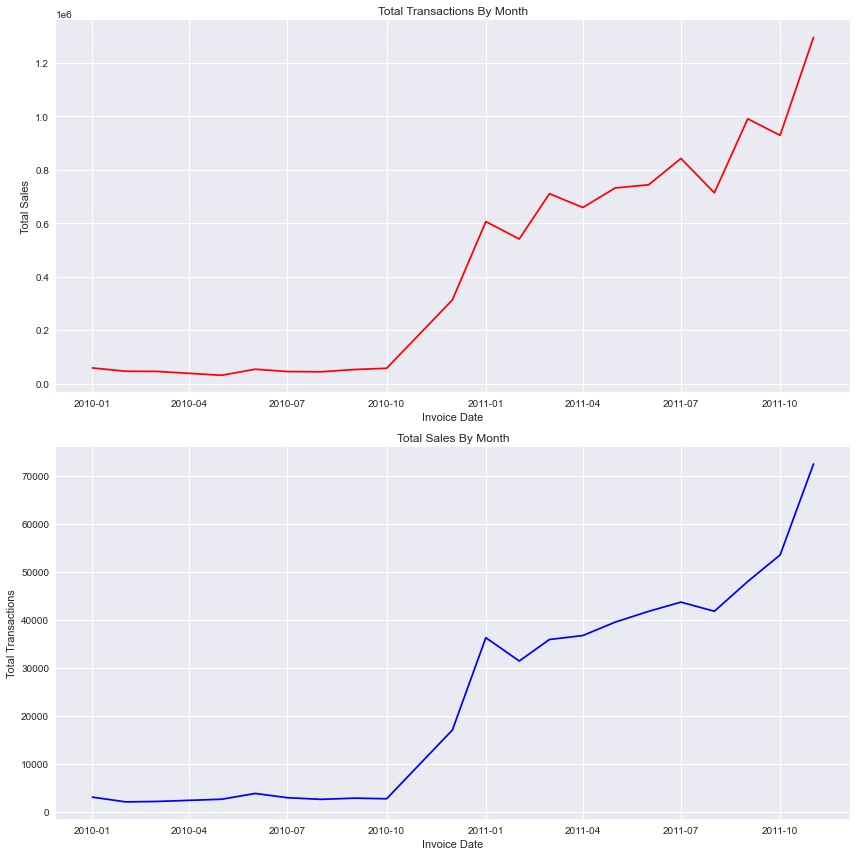

In [20]:
#Monthly total transactions lineplot
fig,ax=plt.subplots(2,1,figsize=(12,12))
ax[0].plot(df_trans_date.index[:-1],df_sales_date['Total'][:-1],color='r')
ax[1].plot(df_trans_date.index[:-1],df_trans_date['InvoiceNo'][:-1],color='b')
ax[0].set_xlabel('Invoice Date')
ax[0].set_ylabel('Total Sales')
ax[1].set_xlabel('Invoice Date')
ax[1].set_ylabel('Total Transactions')
ax[1].set_title('total sales by month'.title())
ax[0].set_title('total transactions by month'.title())
fig.tight_layout()


* We notice an upward trend in the number of transactions and sale's income  and it starts at the fall of the year 2010.

In [21]:
#Including only the positive quantity and unit prices n the dataframe
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]

As i stated previously, the orders with a negatie quantity are canceled, so it is suitable to not include in our analysis.

## RFM Analysis

The RFM segmentation technique is the idea that marketers can gain an extensive understanding of their customers by analyzing three quantifiable factors which are Recency(R),Freqency(F) and Monetary(M).

* **Recency** is simply the amount of time since the customer’s most recent transaction (most businesses use days, though for others it might make sense to use months, weeks or even hours instead).


* **Frequency** is the total number of transactions made by the customer (during a defined period).


* **Monetary** is the total amount that the customer has spent across all transactions (during a defined period).

The trick is to basically  assign a score to each customer for each value of the three dimensions, then divide the customers into tiered groups using the overall score which is a combination of all three values .

There is no conventinal number of levels but it is common to divide them into 4 or 5 groups, which means each dimension can take also 4 or 5 values.

Another common way to segment customers is to label specific groups based on their overall score, e.g., 'Best Customers'(R=Highest,F=Highest,M=Highest),'Low spending active customers (R=High,F=High,M=Low)', and for each customers segment, we try to invest in a marketing strategy to imporve their purchase behaviour.









## Monetary:

In [22]:
#Monetary dataframe
rfm_m=df.groupby(['CustomerID'])[['Total']].sum()
rfm_m.reset_index()
rfm_m.head()

,Total
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


## Recency:

In [23]:
#Recency dataframe
df['days_diff']=df['InvoiceDate'].max()-df['InvoiceDate']
rfm_r=df.groupby(['CustomerID'])[['days_diff']].min()
rfm_r.reset_index()
rfm_r.head()

,days_diff
CustomerID,
12346.0,326 days 07:18:00
12347.0,40 days 04:54:00
12348.0,76 days 04:06:00
12349.0,19 days 07:28:00
12350.0,311 days 01:18:00


## Frequency:

In [24]:
#Frequency dataframe
rfm_f=df.groupby(['CustomerID'])[['InvoiceNo']].count()
rfm_f.reset_index()
rfm_f.head()

,InvoiceNo
CustomerID,
12346.0,1
12347.0,182
12348.0,31
12349.0,73
12350.0,17


In [25]:
#Merging all the dataframes into one
rfm=rfm_f.merge(rfm_m,how='inner',on='CustomerID')
rfm=rfm.merge(rfm_r,how='inner',on='CustomerID')
rfm.columns=['Frequency','Monetary','Recency']
RFM=rfm.copy()
rfm.head()


,Frequency,Monetary,Recency
CustomerID,,,
12346.0,1,77183.60,326 days 07:18:00
12347.0,182,4310.00,40 days 04:54:00
12348.0,31,1797.24,76 days 04:06:00
12349.0,73,1757.55,19 days 07:28:00
12350.0,17,334.40,311 days 01:18:00


In [26]:
#Dividing each dimension using quantiles then assigning scores to all 3 RFM factors.
rfm['Recency_score']=pd.qcut(rfm['Recency'].sort_values(ascending=True),q=5,labels=[5,4,3,2,1]).astype('int64')
rfm['Frequency_score']=pd.qcut(rfm['Frequency'].sort_values(ascending=True),q=5,labels=[1,2,3,4,5]).astype('int64')
rfm['Monetary_score']=pd.qcut(rfm['Monetary'].sort_values(ascending=True),q=5,labels=[1,2,3,4,5]).astype('int64')
rfm.head()

,Frequency,Monetary,Recency,Recency_score,Frequency_score,Monetary_score
CustomerID,,,,,,
12346.0,1,77183.60,326 days 07:18:00,1,1,5
12347.0,182,4310.00,40 days 04:54:00,4,5,5
12348.0,31,1797.24,76 days 04:06:00,3,3,4
12349.0,73,1757.55,19 days 07:28:00,4,4,4
12350.0,17,334.40,311 days 01:18:00,1,2,2


In [27]:
rfm.info()    

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 12346.0 to nan
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   Frequency        4339 non-null   int64          
 1   Monetary         4339 non-null   float64        
 2   Recency          4339 non-null   timedelta64[ns]
 3   Recency_score    4339 non-null   int64          
 4   Frequency_score  4339 non-null   int64          
 5   Monetary_score   4339 non-null   int64          
dtypes: float64(1), int64(4), timedelta64[ns](1)
memory usage: 237.3+ KB


In [28]:
#Overall rfm score
rfm['rfm_score']=rfm['Recency_score']+rfm['Frequency_score']+rfm['Monetary_score']

In [29]:
#Function to segment customers into 4 levels (bronze,silver,golden and platinum)
def segments(rfm):
    
    if rfm['rfm_score']<=4:
        return 'Bronze Customer'
    elif (rfm['rfm_score'] > 4) and (rfm['rfm_score'] <9):
        return 'Silver Customer'
    elif (rfm['rfm_score'] >=9 ) and (rfm['rfm_score'] <13):
        return 'Golden Customer'
    else:
        return 'Platinum'
    

In [30]:
rfm['Segment']=rfm.apply(segments,axis=1)
rfm.head()

,Frequency,Monetary,Recency,Recency_score,Frequency_score,Monetary_score,rfm_score,Segment
CustomerID,,,,,,,,
12346.0,1,77183.60,326 days 07:18:00,1,1,5,7,Silver Customer
12347.0,182,4310.00,40 days 04:54:00,4,5,5,14,Platinum
12348.0,31,1797.24,76 days 04:06:00,3,3,4,10,Golden Customer
12349.0,73,1757.55,19 days 07:28:00,4,4,4,12,Golden Customer
12350.0,17,334.40,311 days 01:18:00,1,2,2,5,Silver Customer


In [31]:
#Grouping by segments and aggregating by RFM dimensions
rfm_seg=rfm.groupby('Segment').agg({'Frequency':'mean','Recency_score':'mean','Monetary':'sum'}).round(1)
rfm_seg=rfm_seg.merge(rfm_seg['Monetary']/rfm_seg['Monetary'].sum(),how='inner',on='Segment')
columns={'Frequency':'Average_Frequency','Recency_score':'Average_Recency','Monetary_x':'Monetary Total','Monetary_y':'Monetary_ratio'}
rfm_seg.rename(columns,axis=1,inplace=True)
rfm_seg['Monetary_ratio']=rfm_seg['Monetary_ratio'].round(2)
rfm_seg=rfm_seg.sort_values(by=['Monetary_ratio'])
rfm_seg.head()

,Average_Frequency,Average_Recency,Monetary Total,Monetary_ratio
Segment,,,,
Bronze Customer,9.0,1.3,85380.4,0.01
Silver Customer,25.3,2.3,937890.5,0.09
Golden Customer,76.7,3.4,1929071.2,0.18
Platinum,412.6,4.5,7689768.7,0.72


In [32]:

rfm_agg=rfm.groupby('rfm_score').agg({'Frequency_score':'mean','Recency_score':'mean','Monetary_score':'mean'}).round(1)
rfm_agg

,Frequency_score,Recency_score,Monetary_score
rfm_score,,,
3,1.0,1.0,1.0
4,1.2,1.5,1.2
5,1.7,1.7,1.6
6,1.8,2.3,1.9
7,2.2,2.6,2.2
8,2.6,2.7,2.7
9,2.9,3.1,3.0
10,3.3,3.3,3.4
11,3.7,3.6,3.7


In [33]:
#Display value on top of the barchart.
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

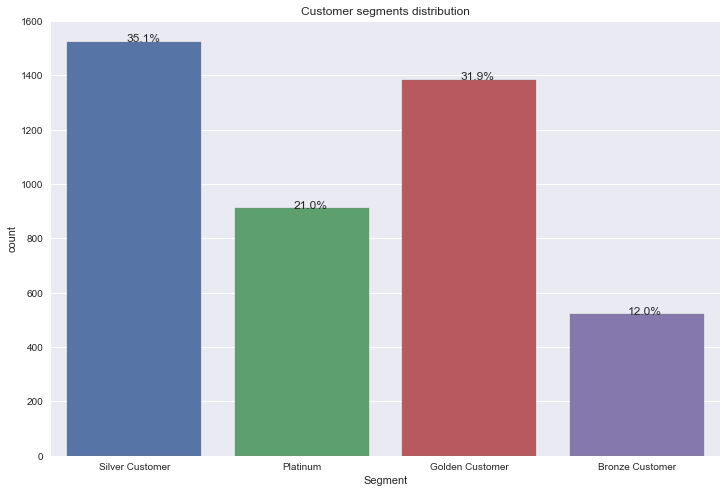

In [34]:
#Barplot to showcase customers distribution by segments.
plt.figure(figsize=(12,8))
ax=sns.countplot(rfm['Segment'],saturation=0.8,edgecolor='.5')
plt.title('Customer segments distribution')
without_hue(ax,rfm['Segment'])

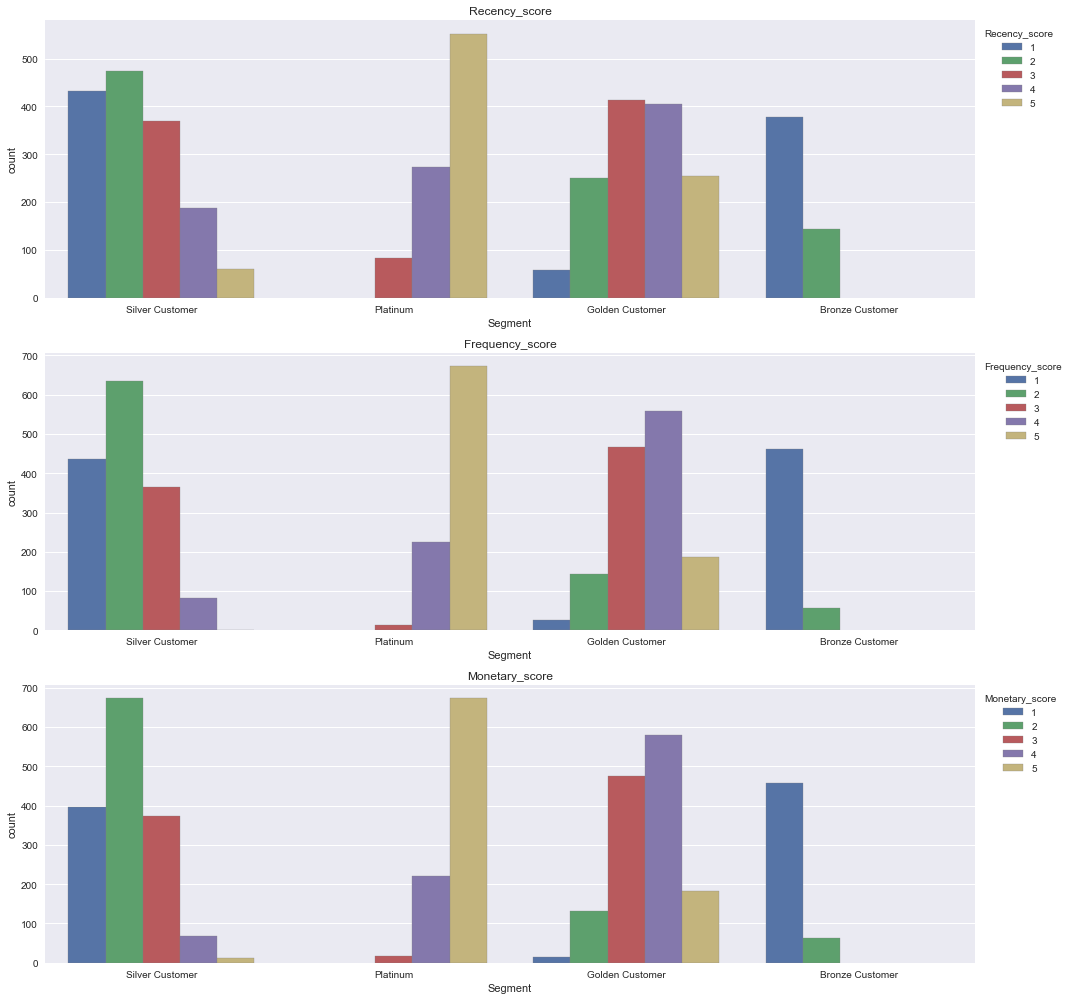

In [35]:
fig,ax=plt.subplots(3,1,figsize=(15,14))

for col,i in zip(['Recency_score','Frequency_score','Monetary_score'],range(0,3)):
    sns.countplot(rfm['Segment'],ax=ax[i],hue=rfm[col],saturation=0.8,edgecolor='.5')
    ax[i].set_title(col)
    ax[i].legend(bbox_to_anchor=(1,1),title=col)
    
    
fig.tight_layout()

### Platinum
* Platinum Customers are the company's biggest asset,although they represent 20%, they're the most contributing segment of clients to the total reveue with a precentage of 72%. So it is wise to think of ways to establish a strong bond with them,keep them around and make them feel valued,the key is to make sure they keep on the same behaviour.
* One way to approach this is by establishing a personalized communication  to gauge their interest,offering occasional gifts, vip exclusive products or discount codes.

### Golden
* Despite the strong presence of the golden segment, a good chunk of clients have a RFM scores of 3 or less, which is a risky situation because it's either they're not spending enough, or they've been away for a while, So it is wise to give them a reminder with the lastest discounts,products that may catch their interest based on their latest transactions.
* The monetary scores of golden customers revolves mostly around 4 and 3, it's important to motivate them to spend more and buy higher quality items, a cross-selling recommendation system would be highly beneficial in this case, as it suggests newer products of different categories.

### Silver and bronze
* Silver and bronze segment represent a largest part of our customers , but their monetary value is quite low and they're not frequent enough, they can be just passing by, not that interested in the business's products, or simply lost customers.
* It would not be wise to waste resources on marketing strategies that targets them to win back this type of client because they're unlikely to start buying again.




**In the next section, i am going to approach segmenting customers in a different way using KMeans clustering then try to compare both approaches outcomes.**

## KMeans Clustering

In [36]:
RFM['Recency']=RFM['Recency'].dt.days #Using days as unit for recency

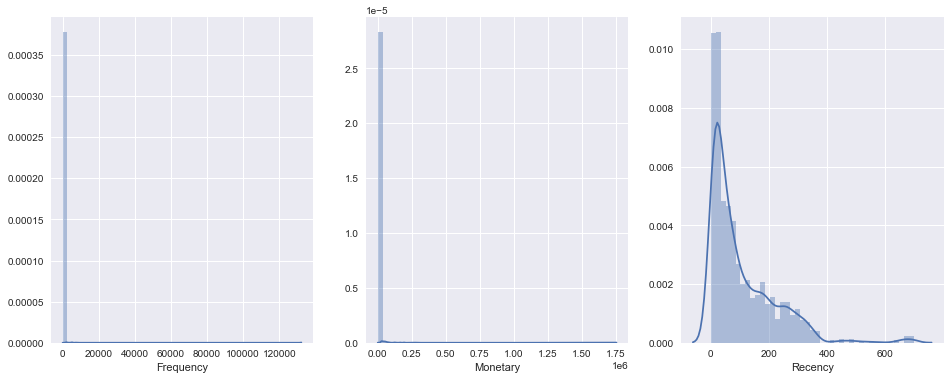

In [37]:
fig,ax=plt.subplots(1,3,figsize=(16,6))    #RFM Distribution plots
for col,i in zip(RFM.columns,range(0,3)):
    sns.distplot(RFM[col],ax=ax[i])

* Both frequency and monetary data are heavily skewed, so before feeding it to the model, it's recommended to normalize the distributions and that will help with the performance of the clustering.

In [38]:
#Function to normalize data using powers inferiot between 1 and 0.

interval=np.arange(0.1,0.9,0.1)
def unskew_power(df,col):
    skew=[]
    power=[]    
    for i in interval:
        skew.append(abs(np.power(df[col],i).skew()))
        power.append(i)
    table= np.array([skew,power]).T
    min_power=table[:,0].min()
    return np.power(df[col]+abs(df[col].min()),min_power)
     
        

    
    

In [39]:
def unskew_log2(df,col):
    return np.log(df[col]+abs(min(df[col]))+1)

In [40]:
#Function to normalize data using Logarithmic tranformation.
def unskew_log3(df):
    return df.apply(unskew_log).apply(np.log,axis=1)

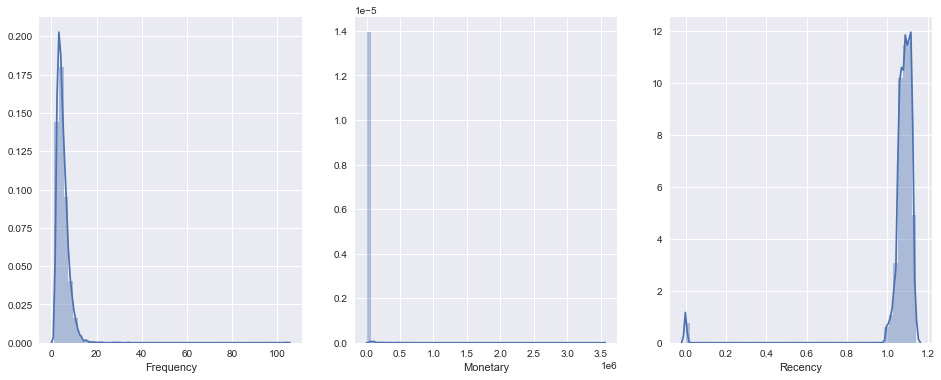

In [41]:
fig,ax=plt.subplots(1,3,figsize=(16,6))
for col,i in zip(RFM.columns,range(0,3)):
    sns.distplot(unskew_power(RFM,col),ax=ax[i])

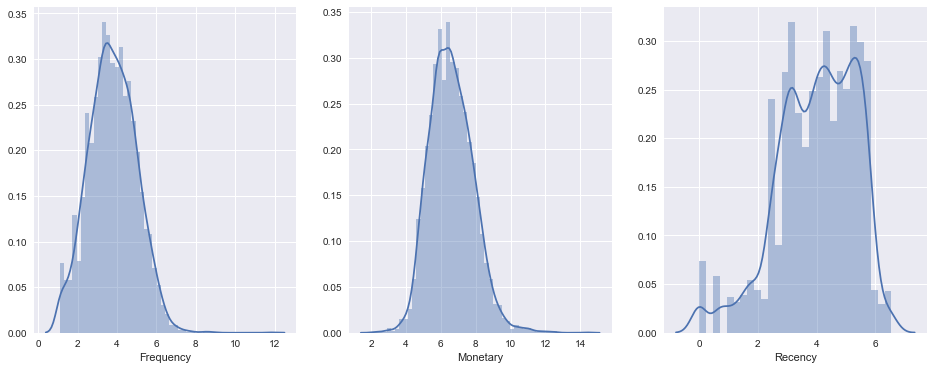

In [42]:
fig,ax=plt.subplots(1,3,figsize=(16,6))
for col,i in zip(RFM.columns,range(0,3)):
    sns.distplot(unskew_log2(RFM,col),ax=ax[i])

* As we can all three distribution are much closer to the infamous normal bell curve.The logarithmic function was more efficient as it reduced skewness more than the power function.


In [43]:
#Applying the log function to the RFM dataframe
unskewed_log_rfm=pd.DataFrame({'Frequency':unskew_log2(RFM,'Frequency'),'Recency':unskew_log2(RFM,'Recency'),'Monetary':unskew_log2(RFM,'Monetary')})
unskewed_log_rfm.head()

,Frequency,Recency,Monetary
CustomerID,,,
12346.0,1.098612,5.789960,11.254004
12347.0,5.214936,3.713572,8.369795
12348.0,3.496508,4.343805,7.496647
12349.0,4.317488,2.995732,7.474375
12350.0,2.944439,5.743003,5.826442


In [44]:
#Scaling the data using the standardcaler
scaler=StandardScaler()
scaled_rfm=scaler.fit_transform(unskewed_log_rfm)
scaled_rfm=pd.DataFrame(scaled_rfm,index=unskewed_log_rfm.index,columns=unskewed_log_rfm.columns)
scaled_rfm.head()

,Frequency,Recency,Monetary
CustomerID,,,
12346.0,-2.236890,1.344675,3.715751
12347.0,1.199021,-0.212779,1.412641
12348.0,-0.235357,0.259946,0.715412
12349.0,0.449918,-0.751215,0.697627
12350.0,-0.696171,1.309454,-0.618286


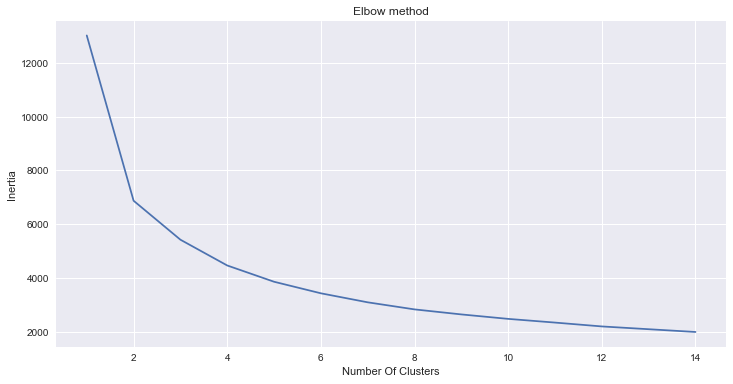

In [45]:
# Elbow method plot to determine the optimal number of clusters
inertia=[]
for i in range(1,15):
        KM=KMeans(n_clusters=i,init='k-means++', n_init=10, max_iter=400)
        KM.fit(scaled_rfm)
        km_iner=KM.inertia_
        inertia.append(km_iner)
    
plt.figure(figsize=(12,6))
plt.plot(range(1,15),inertia)
plt.xlabel('number of clusters'.title())
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()   

* The elbow method  suggests that the optimal number of clusters is where the bend occurs,and when we examine the plot, we can clearly notice the change of the slop at n_clusters=2, therefore, 2 is the optimale number of segments.


In [46]:
#Silhouette score
for i in range(2,15):
    KM=KMeans(n_clusters=i,init='k-means++', n_init=10, max_iter=400)
    KM.fit(scaled_rfm)
    labels=KM.predict(scaled_rfm)
    silhouette_avg = silhouette_score(scaled_rfm,labels)
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.4020718462687174
For n_clusters = 3 The average silhouette_score is : 0.2988260164367673
For n_clusters = 4 The average silhouette_score is : 0.3029142820640632
For n_clusters = 5 The average silhouette_score is : 0.2717918234910675
For n_clusters = 6 The average silhouette_score is : 0.2813261803684853
For n_clusters = 7 The average silhouette_score is : 0.2797649106760393
For n_clusters = 8 The average silhouette_score is : 0.2660783523219066
For n_clusters = 9 The average silhouette_score is : 0.25526507461741965
For n_clusters = 10 The average silhouette_score is : 0.25638452503311204
For n_clusters = 11 The average silhouette_score is : 0.2672908873398307
For n_clusters = 12 The average silhouette_score is : 0.26526608569475246
For n_clusters = 13 The average silhouette_score is : 0.2573549475780618
For n_clusters = 14 The average silhouette_score is : 0.25530376800992033


The n_clusters with the highest slihouette score is the optimal number of clusters, in our case it is 2 once again.

In [47]:
#Counting customers for each cluster

KM=KMeans(n_clusters=2,init='k-means++', n_init=10, max_iter=50)
KM.fit(unskewed_log_rfm)
labels=KM.predict(unskewed_log_rfm)
unskewed_log_rfm['Label']=labels
unskewed_log_rfm['Label'].value_counts()




0    2447
1    1892
Name: Label, dtype: int64

In [48]:
# Function that returns a scatter plot highlighting clusters in different colors.

def scatter_plot(col1,col2):
    plt.scatter(unskewed_log_rfm[unskewed_log_rfm['Label']==0][col1],unskewed_log_rfm[unskewed_log_rfm['Label']==0][col2],color='r',label='0')
    plt.scatter(unskewed_log_rfm[unskewed_log_rfm['Label']==1][col1],unskewed_log_rfm[unskewed_log_rfm['Label']==1][col2],color='g',label='1')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend()
    

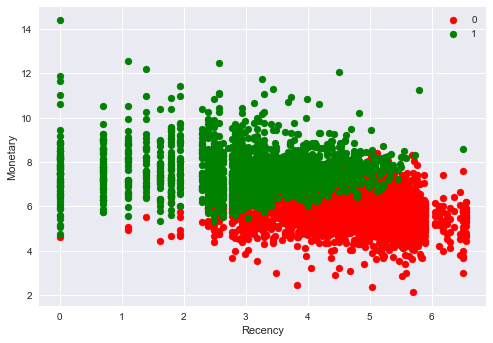

In [49]:
scatter_plot('Recency','Monetary')

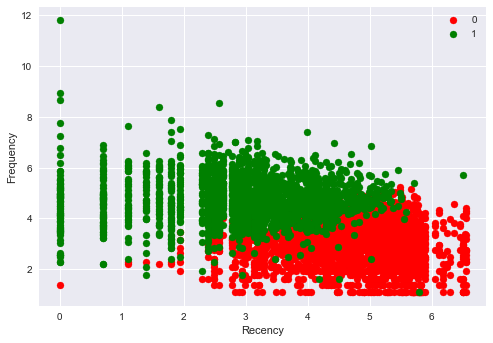

In [50]:
scatter_plot('Recency','Frequency')

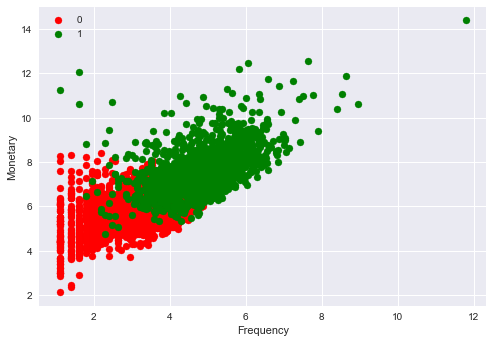

In [51]:
scatter_plot('Frequency','Monetary')

The KMeans algorithm classified customers into 2 categories we labeled as 0 and 1, and through the plots we can notice some patterns within the scatter plot:

* The '0' class are much higher on both the monetary and frequency dimensions, this class's customers are frequent big spenders compared to class1 although we can see some interference of both clusters.

* However when it comes to the recency factor, class '1' has a higher density on the upper part of the axis which as a result will increase the mean compared to the other class.

* Customers of class 1 are comparatively new customers but generally lack the loyalty and aptiture to spend more, the top section of this cluster needs to be targeted with a marketing strategy to motivate them to keep buy higher value items. 

In [52]:
# Agregating by the mean while gruping by labels
unskewed_log_rfm['Segment']=rfm['Segment']
unskewed_log_rfm.groupby(['Label'])[['Frequency','Recency','Monetary']].mean()


,Frequency,Recency,Monetary
Label,,,
0,3.030836,4.736943,5.813946
1,4.745422,3.040569,7.618308


* The table backs our interpretation of the scatterplots, class '0' has both a high average frequency and monetary values, while the class 1's average recency is higher.

In [53]:
unskewed_log_rfm.head()

,Frequency,Recency,Monetary,Label,Segment
CustomerID,,,,,
12346.0,1.098612,5.789960,11.254004,1,Silver Customer
12347.0,5.214936,3.713572,8.369795,1,Platinum
12348.0,3.496508,4.343805,7.496647,0,Golden Customer
12349.0,4.317488,2.995732,7.474375,1,Golden Customer
12350.0,2.944439,5.743003,5.826442,0,Silver Customer


Text(0.5, 1.0, 'Class distribution')

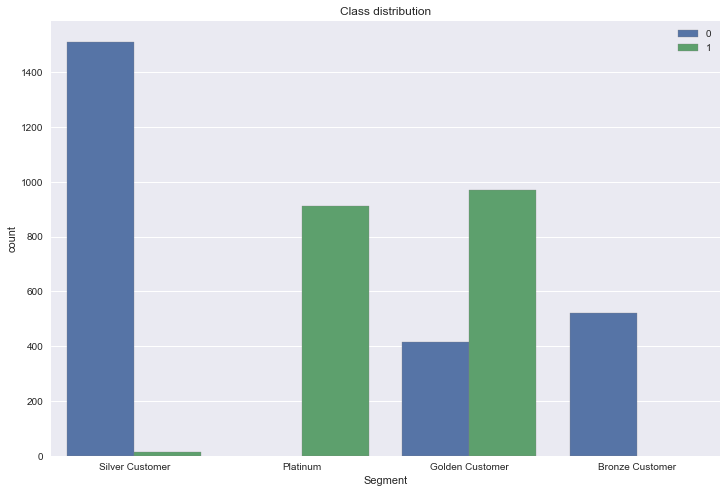

In [60]:
plt.figure(figsize=(12,8))
sns.countplot(unskewed_log_rfm['Segment'],hue=unskewed_log_rfm['Label'],saturation=0.8,edgecolor='.5')
plt.legend(loc='upper right')
plt.title('Class distribution')


* The barchat clarifies the fact that the clusters produced by the model actually divided the customers according to the RFM labels, both golden and platinum belong to class '1'  while the rest belong to class '0'.

* Both techniques overlap at the silver and specially the golden level, those customers represent the interference we see in the scatterplot. 
